In [1]:
from Classes import Hamiltonian
from Classes import CrankNicolson
from Classes import WaveFunction
import pyximport; pyximport.install()
from Classes.Functions import TDMAsolver,TriDot,Math,GroundState
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import sparse,linalg,integrate
import numpy as np

import PyQt5

%matplotlib notebook


In [2]:
c = 137.04
Nx = 2000 #Número de puntos en el mallado espacial
Nt = 4*1024 #Número de puntos en el mallado temporal
x,h = np.linspace(-100,100,Nx,retstep=True) 
a = 1.0 #Paramentro que define el ancho de la función gaussiana
#p0 = 0.0 
x0 = 0.0  #Centro de la función gaussiana a tiempo 0
tmax = 110*4
t,dt = np.linspace(0,tmax,Nt,retstep=True) #Mallado temporal equiespaciado
psi = np.exp(-(x-x0)**2/(2*a**2)) #Funcíón Gaussiana
C = integrate.simps(np.conjugate(psi)*psi,x) #Constante de normalización
psin = psi.astype(complex)/np.sqrt(1) #Normalizamos la función de onda
H=[0,0,0]
M=[0,0,0]
Mp=[0,0,0]

#H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,tmax=tmax,softening=2.0) 
#WF = WaveFunction.WF(a,(x,h),(t,dt),H)
#psi0 = WF.WaveFunction()


In [3]:
def Mask(x,xb,gamma):
    mask = np.ones(len(x),dtype='float')
    
    for i in range(len(x)):
        if x[i]<(x[0]+xb):
            mask[i] = np.power(np.cos(np.pi*(x[i]-(x[0]+xb))*gamma/(2*xb)),1/8)
        if x[i]>(x[-1]-xb):
            mask[i] = np.power(np.cos(np.pi*(x[i]-(x[-1]-xb))*gamma/(2*xb)),1/8)
    

    return mask

def EigenEnergy(psi,H,x):
    ##################################################
    #   Return the eigenenegy given the hamiltonian
    #   and the eigenfunction, aka wavefunction
    ##################################################

    integ = np.conjugate(psi)*(TriDot.TriDot(H[0],H[1],H[2],psi))
    return integrate.simps(integ,x)

def EigenEnergy2(psi,H,x):
    ##################################################
    #   Return the eigenenegy given the hamiltonian
    #   and the eigenfunction, aka wavefunction
    ##################################################

    integ = np.conjugate(psi)*(np.dot(H,psi))
    return integrate.simps(integ,x)

mask = Mask(x,15,1)

mask = Mask(x,15,1)


In [4]:
H[1] = (1/h**2)*np.ones(Nx).astype(complex)
H[0] = (-1/(2*h**2))*np.ones(Nx-1)
H[2] = (-1/(2*h**2))*np.ones(Nx-1)

In [5]:
M[0] = np.ones(Nx-1)+1j*H[0]*(dt)/2
M[1] = np.ones(Nx)+1j*H[1]*(dt)/2
M[2] = np.ones(Nx-1)+1j*H[2]*(dt)/2

Mp[0] = np.ones(Nx-1)-1j*H[0]*(dt)/2
Mp[1] = np.ones(Nx)-1j*H[1]*(dt)/2
Mp[2] = np.ones(Nx-1)-1j*H[2]*(dt)/2

In [8]:
def Propagate(psi0):
    #self.MatrixSetup()
    #BandedMatrix=np.zeros((3,self.N))
    #BandedMatrix[0]=np.append(0,np.diag(self.M,k=1))
    #BandedMatrix[1]=np.diag(self.M)
    #BandedMatrix[2]=np.append(np.diag(self.M,k=1),0)
    A = M
    b = TriDot.TriDot(Mp[0],Mp[1],Mp[2],psi0)
    #A = sparse.diags([self.M[1],self.M[0],self.M[2]],[0,1,-1]).toarray()
    psi = TDMAsolver.TDMAsolver(A[0],A[1],A[2],b)
    #psi = linalg.solve(A,b)
    return psi

/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


CPU times: user 599 ms, sys: 9.66 ms, total: 609 ms
Wall time: 674 ms


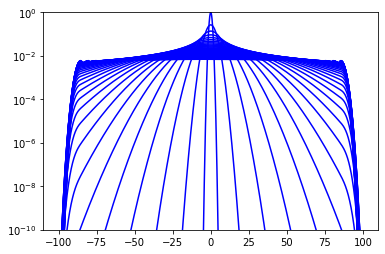

In [9]:
%%time
fig = plt.figure();
ax = fig.add_subplot(111);
ax.set_ylim(1E-10,1)
#H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,tmax=tmax,softening=1.0) 
#WF = WaveFunction.WF(a,(x,h),(t,dt),H)
#WF.mask =mask
#psi0 = WF.WaveFunction()
psi0 = psin
#Prop = CrankNicolson.Propagator(H,Nx,dt)
#Parray = []

for i in range(len(t)):
    #H.Update(i)
    #Prop.Update(H)
    
    psi1 = mask*np.asarray(Propagate(psi0))
    if (i%100==0):
        ax.plot(x,np.conjugate(psi1)*psi1,'b')
        #print(WF.Energy())
    psi0 = psi1
ax.set_yscale('log')

In [67]:
idt = -1j*0.1
V = -1/(np.sqrt(np.power(x,2)+2))*np.ones(Nx)
H[1] = (1/h**2 + V).astype(complex)
H[0] = (-1/(2*h**2))*np.ones(Nx-1).astype(complex)
H[2] = (-1/(2*h**2))*np.ones(Nx-1).astype(complex)

M[0] = np.zeros(Nx-1)+1j*H[0]*(idt)/2
M[1] = np.ones(Nx)+1j*H[1]*(idt)/2
M[2] = np.zeros(Nx-1)+1j*H[2]*(idt)/2

Mp[0] = np.zeros(Nx-1)-1j*H[0]*(idt)/2
Mp[1] = np.ones(Nx)-1j*H[1]*(idt)/2
Mp[2] = np.zeros(Nx-1)-1j*H[2]*(idt)/2

In [68]:
K = np.zeros((Nx,Nx))
A = sparse.diags([H[1],H[0],H[2]],[0,1,-1]).toarray()

for i in range(Nx):
    try:
        K[i,i] = 1/h**2 + V[i]
        K[i,abs(i-1)] = -1/(2*h**2)
        K[i,abs(i+1)] = -1/(2*h**2)
    except:
        pass
P = np.identity(Nx)+1j*A*idt/2
Pp = np.identity(Nx)-1j*A*idt/2

def Propagate2(psi0):
    #self.MatrixSetup()
    #BandedMatrix=np.zeros((3,self.N))
    #BandedMatrix[0]=np.append(0,np.diag(self.M,k=1))
    #BandedMatrix[1]=np.diag(self.M)
    #BandedMatrix[2]=np.append(np.diag(self.M,k=1),0)
    A = P
    b = np.dot(Pp,psi0)
    #A = sparse.diags([self.M[1],self.M[0],self.M[2]],[0,1,-1]).toarray()
    #psi = TDMAsolver.TDMAsolver(A[1],A[2],A[2],b)
    psi = linalg.solve(A,b)
    return psi

In [70]:
A = sparse.diags([M[1],M[0],M[2]],[0,1,-1]).toarray()
np.allclose(A,P)


True

In [71]:
psi0 = psin.astype(complex)
eps = 1
ep0 = EigenEnergy(psi0,H,x)
delta = 1E-5
count = 0
while(eps>delta):
    psi1 = Propagate(psi0)
    norm = Math.Norm(psi1,x)
    psi1 = psi1/(norm)
    ep1 = EigenEnergy(psi1,H,x)
    eps = abs(ep1-ep0)
   
    #print(ep1)
    ep0 = ep1
    psi0 = psi1
    count += 1

In [72]:
ep1

(-0.4999152643021987+0j)

In [40]:
psi0 = psin.astype(complex)
eps = 1
ep0 = EigenEnergy(psi0,H,x)
delta = 1E-5
count = 0
while(eps>delta):
    psi1 = Propagate2(psi0)
    norm = Math.Norm(psi1,x)
    psi1 = psi1/(norm)
    ep1 = EigenEnergy(psi1,H,x)
    eps = abs(ep1-ep0)
   
    #print(ep1)
    ep0 = ep1
    psi0 = psi1
    count += 1

In [54]:
#psiG = psi1
Propagate2(psiG)
#np.allclose(np.asarray(Propagate(psiG)),Propagate2(psiG))

array([2.65897690e-170+0.j, 6.11853571e-170+0.j, 1.14199963e-169+0.j, ...,
       1.14199963e-169+0.j, 6.11853571e-170+0.j, 2.65897690e-170+0.j])

In [51]:
np.asarray(Propagate(psiG))

array([5.97320876e-171+0.j, 1.37517674e-170+0.j, 2.56859933e-170+0.j, ...,
       2.56859933e-170+0.j, 1.37517674e-170+0.j, 5.97320876e-171+0.j])

In [25]:

#b =np.random.rand(Nx).astype(complex)
#a =np.random.rand(Nx-1).astype(complex)
#c =np.random.rand(Nx-1).astype(complex)
#d =np.random.rand(Nx).astype(complex)
b =np.array([2,2,2]).astype(complex)
a =np.array([3,3]).astype(complex)
c =np.array([1,1]).astype(complex)
d =np.array([1,2,3]).astype(complex)
A=np.array([[2,3,0],
            [1,2,3],
            [0,1,2]])
#A = sparse.diags([b,a,c],[0,1,-1]).toarray()

s1 =TriDot.TriDot(a,b,c,d)
s2 = np.dot(A,d)

In [23]:
s2

array([ 8.+0.j, 14.+0.j,  8.+0.j])

In [16]:
A = sparse.diags([H.H[1],H.H[0],H.H[2]],[0,1,-1]).toarray()
integ = np.conjugate(psi0)*np.dot(A,psi0)
integrate.simps(integ,x)
psi1

(-0.3918865710516353+0j)

In [16]:
A

array([[ 24.94002601+0.j, -12.4750125 +0.j,   0.        +0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       [-12.4750125 +0.j,  24.94000596+0.j, -12.4750125 +0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       [  0.        +0.j, -12.4750125 +0.j,  24.93998583+0.j, ...,
          0.        +0.j,   0.        +0.j,   0.        +0.j],
       ...,
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
         24.93998583+0.j, -12.4750125 +0.j,   0.        +0.j],
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
        -12.4750125 +0.j,  24.94000596+0.j, -12.4750125 +0.j],
       [  0.        +0.j,   0.        +0.j,   0.        +0.j, ...,
          0.        +0.j, -12.4750125 +0.j,  24.94002601+0.j]])

In [47]:
K = np.zeros((Nx,Nx))

for i in range(Nx):
    try:
        K[i,i] = 1/h**2 + H.V[i]
        K[i,abs(i-1)] = -1/(2*h**2)
        K[i,abs(i+1)] = -1/(2*h**2)
    except:
        pass
A = sparse.diags([H.H[1],H.H[0],H.H[2]],[0,1,-1]).toarray()

In [57]:
np.ones(Nx-1)

array([1., 1., 1., ..., 1., 1., 1.])